In [1]:
import re

In [1]:
import sys
import os

In [2]:
script_path = "configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper.py"

In [3]:
script_path = script_path[:-3]

In [4]:
script_path

'configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [5]:
new_path = script_path.replace("configs", "../results")

In [6]:
new_path

'../results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [7]:
with open(new_path + "/test_file.txt", 'w') as f:
    f.write("test")

In [7]:
new_path = os.path.dirname(new_path)

NameError: name 'os' is not defined

In [8]:
import_name = new_path + "/"

In [9]:
script = __import__(import_name)

ModuleNotFoundError: No module named 'results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [1]:
import tensorflow as tf

In [227]:
import pennylane as qml
import numpy as np

In [409]:
def variational_layer(wires, params):
    [qml.RY(params[i], wires[i]) for i in range(len(wires))]
    params = params[len(wires):]
    [qml.RZ(params[i], wires[i]) for i in range(len(wires))]

In [410]:
def entangling_layer(wires):
    qml.CZ(wires = [0,1])
    qml.CZ(wires = [1,2])
    qml.CZ(wires = [2,3])
    qml.CZ(wires = [3,0])

In [411]:
def data_encoding(wires, data):
    [qml.RX(data, wires[i], id = "x") for i in range(len(wires))]

In [412]:
dev = qml.device("default.qubit", wires = 4)

num_layers = 2

@qml.qnode(dev)
def schuld_datareup(params, data):
    for l in range(num_layers):
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
        data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers])
    return qml.expval(qml.PauliZ(0))

In [413]:
@qml.qnode(dev)
def basic_datareup(params, data):
    for l in range(num_layers-1):
        data_encoding(range(4), data)
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
    data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers-1])
    return qml.expval(qml.PauliZ(0))

In [414]:
data = np.random.uniform(-0.05,0.05)
params_schuld =[[np.random.uniform(0, np.pi) for i in range(8)] for j in range(num_layers + 1)]
params_basic = params_schuld[:-1]

In [415]:
print(qml.draw(schuld_datareup)(params_schuld, data))

0: ──RY(1.59)──RZ(1.23)─╭●───────╭Z──RX(-0.02)──RY(1.10)──RZ(0.14)─╭●───────╭Z──RX(-0.02)──RY(0.86)
1: ──RY(1.82)──RZ(1.04)─╰Z─╭●────│───RX(-0.02)──RY(1.06)──RZ(2.24)─╰Z─╭●────│───RX(-0.02)──RY(2.52)
2: ──RY(2.37)──RZ(0.29)────╰Z─╭●─│───RX(-0.02)──RY(0.90)──RZ(1.50)────╰Z─╭●─│───RX(-0.02)──RY(2.93)
3: ──RY(1.36)──RZ(1.80)───────╰Z─╰●──RX(-0.02)──RY(2.92)──RZ(0.97)───────╰Z─╰●──RX(-0.02)──RY(0.49)

───RZ(0.65)─┤  <Z>
───RZ(2.99)─┤     
───RZ(0.74)─┤     
───RZ(1.92)─┤     


In [416]:
print(qml.draw(basic_datareup)(params_basic, data))

0: ──RX(-0.02)──RY(1.59)──RZ(1.23)─╭●───────╭Z──RX(-0.02)──RY(1.10)──RZ(0.14)─┤  <Z>
1: ──RX(-0.02)──RY(1.82)──RZ(1.04)─╰Z─╭●────│───RX(-0.02)──RY(1.06)──RZ(2.24)─┤     
2: ──RX(-0.02)──RY(2.37)──RZ(0.29)────╰Z─╭●─│───RX(-0.02)──RY(0.90)──RZ(1.50)─┤     
3: ──RX(-0.02)──RY(1.36)──RZ(1.80)───────╰Z─╰●──RX(-0.02)──RY(2.92)──RZ(0.97)─┤     


In [417]:
from pennylane.fourier import coefficients, circuit_spectrum
freqs_schuld = circuit_spectrum(schuld_datareup)(params_schuld, data)
freqs_basic = circuit_spectrum(basic_datareup)(params_basic, data)

In [418]:
for k,v in freqs_schuld.items():
    print(k, ":", v)

for k,v in freqs_basic.items():
    print(k, ":", v)

x : [-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
x : [-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


In [419]:
from functools import partial
partial_schuld_circuit = partial(schuld_datareup, params_schuld)
partial_basic_circuit = partial(basic_datareup, params_basic)

coeffs_schuld = coefficients(partial_schuld_circuit, 1, 8)
coeffs_basic = coefficients(partial_basic_circuit, 1, 8)

In [420]:
coeffs_schuld

array([ 1.26849088e-01+0.00000000e+00j,  3.41042175e-02-1.18091284e-01j,
       -3.25619507e-03+8.89117135e-02j,  7.86752937e-03-4.77947712e-02j,
        6.54491676e-04+1.71420905e-02j,  3.26536184e-18+8.48994078e-17j,
        4.57150657e-17+2.44902138e-17j, -5.71438321e-18-3.42862993e-17j,
        3.67353207e-18+1.95921710e-17j,  3.67353207e-18-1.95921710e-17j,
       -5.71438321e-18+3.42862993e-17j,  4.57150657e-17-2.44902138e-17j,
        3.26536184e-18-8.48994078e-17j,  6.54491676e-04-1.71420905e-02j,
        7.86752937e-03+4.77947712e-02j, -3.25619507e-03-8.89117135e-02j,
        3.41042175e-02+1.18091284e-01j])

In [421]:
coeffs_basic

array([-3.01807956e-03+0.00000000e+00j,  5.84186977e-03-5.42566937e-03j,
       -2.00196345e-03+2.74597018e-03j,  1.94728992e-03-5.42566937e-03j,
       -4.92923671e-04+1.37298509e-03j,  7.47461733e-18+3.26536184e-18j,
       -1.13267239e-17+6.12255344e-19j, -1.85717454e-17+2.75514905e-18j,
       -3.01025544e-17+2.83678310e-17j, -3.01025544e-17-2.83678310e-17j,
       -1.85717454e-17-2.75514905e-18j, -1.13267239e-17-6.12255344e-19j,
        7.47461733e-18-3.26536184e-18j, -4.92923671e-04-1.37298509e-03j,
        1.94728992e-03+5.42566937e-03j, -2.00196345e-03-2.74597018e-03j,
        5.84186977e-03+5.42566937e-03j])

In [422]:
from pennylane.fourier.visualize import *
import matplotlib.pyplot as plt

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

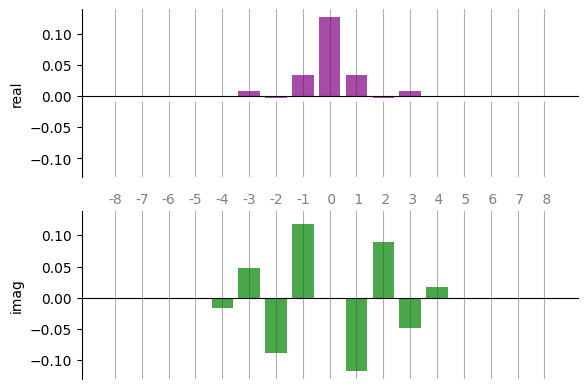

In [423]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_schuld, 1, ax)

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

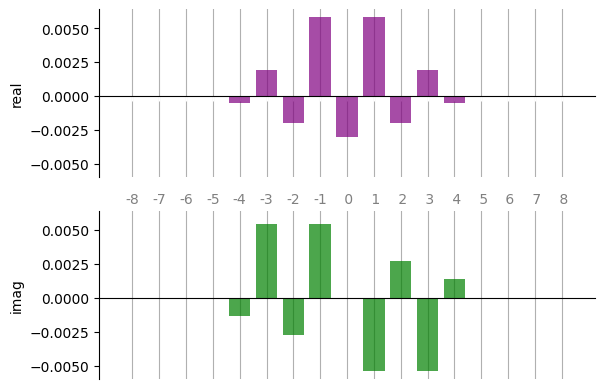

In [424]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_basic, 1, ax)

In [98]:
@qml.qnode(dev)
def simple_circuit(x):
    qml.RX(x[0], wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

In [99]:
coeffs = coefficients(simple_circuit, 1, 2)

In [291]:
dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def simple_circuit(params, data):
    qml.RX(params[0], wires=0)
    qml.RY(data[0], wires = 0, id = "x")
    qml.RX(params[1], wires = 0)
    qml.RY(data[1], wires = 0, id = "x")
    qml.RX(params[2], wires = 0)
    return qml.expval(qml.PauliZ(0))

In [294]:
data = [0,1]
params = [0.5,0.3,0.8]

In [295]:
simple_freqs = circuit_spectrum(simple_circuit)(params, data)

In [296]:
for k,v in simple_freqs.items():
    print(k, ":", v)

x : [-2.0, -1.0, 0, 1.0, 2.0]


In [297]:
from functools import partial

In [301]:
partial_circuit = partial(simple_circuit, params)
coeffs = coefficients(partial_circuit,2,1,lowpass_filter=True)

In [302]:
coeffs

array([[-0.32855821+0.j, -0.04935468+0.j, -0.04935468+0.j],
       [-0.09302078+0.j,  0.29888181+0.j, -0.00682701+0.j],
       [-0.09302078+0.j, -0.00682701+0.j,  0.29888181+0.j]])

In [287]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

In [288]:
def f(x):
    return np.array([simple_circuit(params,x_) for x_ in x])

In [289]:
coeffs = fourier_coefficients(f, 1)

In [290]:
coeffs

array([-0.14167993+0.00000000e+00j,  0.41919332-1.28197512e-16j])

In [1]:
import pennylane as qml
import numpy as np

In [168]:
params = [np.random.uniform(0, np.pi) for i in range(6)]

In [181]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [182]:
results = circuit(params)
results = results[0] * results[1]
results

tensor(0.00106099, requires_grad=True)

In [183]:
@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    #qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [184]:
result = circuit(params)
result

tensor(-0.03021677, requires_grad=True)